# Make a prediction about the coal production

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
sns.set();

In [6]:
df1 = pd.read_csv("../data/cleaned_coalpublic2013.csv", index_col='MSHA ID')
df1.head()

,year,mine_name,mine_state,mine_county,mine_status,mine_type,company_type,operation_type,operating_company,operating_company_address,union_code,coal_supply_region,production_(short_tons),average_employees,labor_hours
MSHA ID,,,,,,,,,,,,,,,
103381,2013,Tacoa Highwall Miner,Alabama,Bibb,"Active, men working, not producing",Surface,Independent Producer Operator,Mine only,"Jesse Creek Mining, Llc","1615 Kent Dairy Rd, Alabaster, AL 35007",,Appalachia Southern,56004,10,22392
103404,2013,Reid School Mine,Alabama,Blount,Permanently abandoned,Surface,Independent Producer Operator,Mine only,"Taft Coal Sales & Associates,","3000 Riverchase Galleria Ste 1, Birmingham, AL...",UNIT,Appalachia Southern,28807,18,28447
100759,2013,North River #1 Underground Min,Alabama,Fayette,"Active, men working, not producing",Underground,Independent Producer Operator,Mine and Preparation Plant,Jim Walter Resources Inc,"3114 County Rd 63 S, Berry, AL 35546",UNIT,Appalachia Southern,1440115,183,474784
103246,2013,Bear Creek,Alabama,Franklin,Active,Surface,Independent Producer Operator,Mine only,"Birmingham Coal & Coke Co., In","912 Edenton Street, Birmingham, AL 35242",,Appalachia Southern,87587,13,29193
103451,2013,Knight Mine,Alabama,Franklin,Active,Surface,Independent Producer Operator,Mine only,"Birmingham Coal & Coke Co., In","P.O. Box 354, Lynn, AL 35242",,Appalachia Southern,147499,27,46393


In [7]:
len(df1)

1061

year
mine_name
mine_state
mine_county
mine_status
mine_type
company_type
operation_type
operating_company
operating_company_address
union_code
coal_supply_region
production_(short_tons)
average_employees
labor_hours


In [18]:
df1['log_production'] = np.log(df1['production_(short_tons)'])

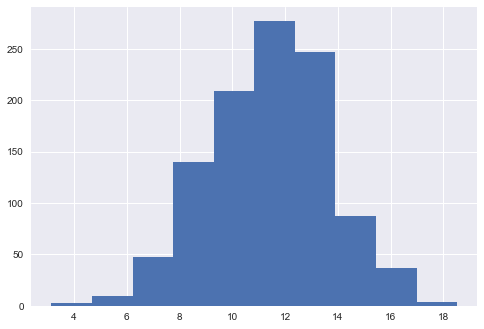

In [19]:
df1.log_production.hist()

In [20]:
df1.mine_status.unique()

array(['Active, men working, not producing', 'Permanently abandoned',
       'Active', 'Temporarily closed', 'New, under construction'], dtype=object)

In [21]:
df1[['mine_status', 'log_production']].groupby('mine_status').mean()

,log_production
mine_status,
Active,11.977453
"Active, men working, not producing",10.499962
"New, under construction",3.951244
Permanently abandoned,9.896046
Temporarily closed,9.162933


# Predict the Production of coal mines

In [23]:
for column in df1.columns:
    print column

year
mine_name
mine_state
mine_county
mine_status
mine_type
company_type
operation_type
operating_company
operating_company_address
union_code
coal_supply_region
production_(short_tons)
average_employees
labor_hours
log_production


In [25]:
df1.union_code.unique()

array([' ', 'UNIT', 'United Mine Workers of America', 'INTE',
       'International Union of Operation Engineers',
       'Scotia Employees Association', 'Western Energy Workers'], dtype=object)

In [26]:
features = ['average_employees',
            'labor_hours']

categoricals = ['mine_state',
                'mine_county',
                'mine_status',
                'mine_type',
                'company_type',
                'operation_type',
                'operating_company',
                'union_code',
                'coal_supply_region']

target = 'log_production'

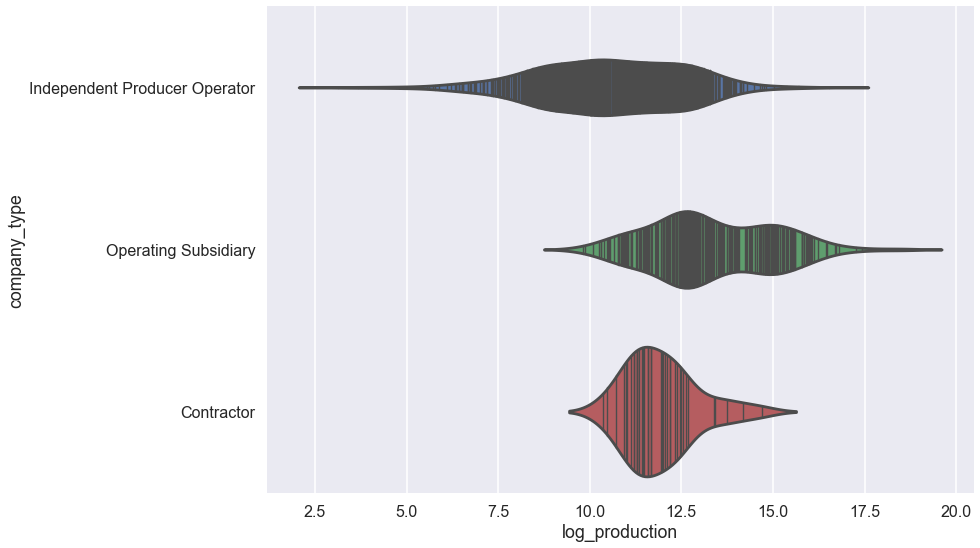

In [28]:
fig = plt.subplots(figsize=(14,8))
sns.set_context('poster')
sns.violinplot(y="company_type", x="log_production", data=df1,
              split=True, inner="stick")
plt.tight_layout()

In [29]:
pd.get_dummies(df1['company_type']).head()

,Contractor,Independent Producer Operator,Operating Subsidiary
MSHA ID,,,
103381,0,1,0
103404,0,1,0
100759,0,1,0
103246,0,1,0
103451,0,1,0


In [32]:
dummy_categoricals = []
for categorical in categoricals:
    print categorical, len(df1[categorical].unique())
    # Avoid the dummy variable trap (need to remove one)!
    drop_var = sorted(df1[categorical].unique())[-1]
    temp_df = pd.get_dummies(df1[categorical], prefix=categorical)
    df1 = pd.concat([df1, temp_df], axis=1)
    temp_df.drop('_'.join([categorical, str(drop_var)]), axis=1, inplace=True)
    dummy_categoricals += temp_df.columns.tolist()

mine_state 29
mine_county 164
mine_status 5
mine_type 3
company_type 3
operation_type 2
operating_company 752
union_code 7
coal_supply_region 8


In [33]:
dummy_categoricals[:10]

['mine_state_Alabama',
 'mine_state_Alaska',
 'mine_state_Arizona',
 'mine_state_Arkansas',
 'mine_state_Colorado',
 'mine_state_Illinois',
 'mine_state_Indiana',
 'mine_state_Kansas',
 'mine_state_Kentucky (East)',
 'mine_state_Kentucky (West)']

# Build our model

In [35]:
from sklearn.cross_validation import train_test_split
from sklearn.ensemble import RandomForestRegressor

/anaconda/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [36]:
len(dummy_categoricals)

964

In [37]:
train, test = train_test_split(df1, test_size=0.3)

In [39]:
rf = RandomForestRegressor(n_estimators=100, oob_score=True)

In [40]:
rf.fit(train[features + dummy_categoricals], train[target])

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=100, n_jobs=1, oob_score=True, random_state=None,
           verbose=0, warm_start=False)

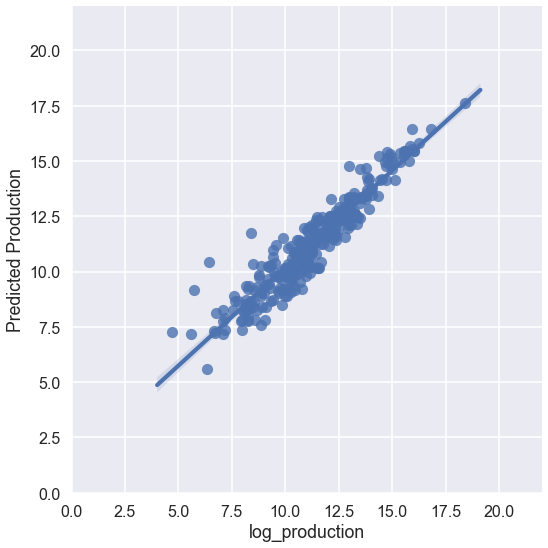

In [42]:
fig = plt.subplots(figsize=(8,8))
sns.regplot(test[target], rf.predict(test[features + dummy_categoricals]))
plt.ylabel("Predicted Production")
plt.xlim(0, 22)
plt.ylim(0, 22)
plt.tight_layout()

In [46]:
from sklearn.metrics import explained_variance_score, r2_score, mean_squared_error

In [47]:
predicted = rf.predict(test[features + dummy_categoricals])
r2_score(test[target], predicted)

0.88875640895368124

In [48]:
explained_variance_score(test[target], predicted)

0.88875641055086696

In [49]:
mean_squared_error(test[target], predicted)

0.55134679428235056

In [50]:
rf_importances = pd.DataFrame({'name':train[features + dummy_categoricals].columns,
                              'importance':rf.feature_importances_
                              }).sort_values(by='importance', ascending=False).reset_index(drop=True)
rf_importances.head(20)

,importance,name
0,0.846740,labor_hours
1,0.035248,average_employees
2,0.009755,coal_supply_region_Powder River Basin
3,0.005555,operating_company_Commonwealth Environmental Sys
4,0.004473,mine_type_Surface
5,0.003709,coal_supply_region_Illinois Basin
6,0.002919,mine_state_West Virginia (Southern)
7,0.002761,coal_supply_region_Appalachia Central
8,0.002376,operating_company_Circle L Land Company Inc
9,0.002234,company_type_Independent Producer Operator
